<a href="https://colab.research.google.com/github/Yashvishe13/Deep-Learning/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# importing libraries
import tensorflow as tf
from keras.layers import BatchNormalization, LeakyReLU, Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys, os

In [5]:
# Load the data
mnist = tf.keras.datasets.mnist
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train / 255. * 2. - 1
print("x_train.shape: ", x_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
x_train.shape:  (60000, 28, 28)


In [6]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
print("x_train.shape: ", x_train.shape)

x_train.shape:  (60000, 784)


In [7]:
# Dimensionality of latent space
latent_dim = 100

In [8]:
# Generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [9]:
# discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [10]:
# Compile both model for training

# Build and compile discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build generator
generator = build_generator(latent_dim)

# create input to represent noise sample
z = Input(shape=(latent_dim, ))
img = generator(z)

# Only Generator should be trained
discriminator.trainable = False

# label fake output as real
fake_pred = discriminator(img)

# combined model
combined_model = Model(z, fake_pred)

# compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [13]:
# Train the GAN

# Training configs
batch_size = 32
epochs = 30000
sample_period = 200

# create batch labels to use for train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store the losses
d_losses = []
g_losses = []

# Create folder to store images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [14]:
# Main training loop
for epoch in range(epochs):
  # Train discriminator
  # selecting random batch of real images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  # Train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.90,       d_acc: 0.42, g_loss: 0.87
epoch: 101/30000, d_loss: 0.02,       d_acc: 1.00, g_loss: 3.99
epoch: 201/30000, d_loss: 0.74,       d_acc: 0.58, g_loss: 1.22
epoch: 301/30000, d_loss: 0.72,       d_acc: 0.39, g_loss: 0.60
epoch: 401/30000, d_loss: 0.71,       d_acc: 0.44, g_loss: 0.64
epoch: 501/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.65
epoch: 601/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.68
epoch: 701/30000, d_loss: 0.66,       d_acc: 0.62, g_loss: 0.74
epoch: 801/30000, d_loss: 0.65,       d_acc: 0.64, g_loss: 0.70
epoch: 901/30000, d_loss: 0.66,       d_acc: 0.53, g_loss: 0.72
epoch: 1001/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.78
epoch: 1101/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.77
epoch: 1201/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.72
epoch: 1301/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.78
epoch: 1401/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.80
epoch: 1501/30000, d_loss: 0.64,     

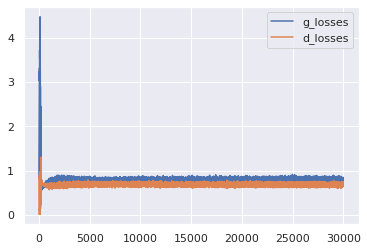

In [15]:
# Plotting loss
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [16]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

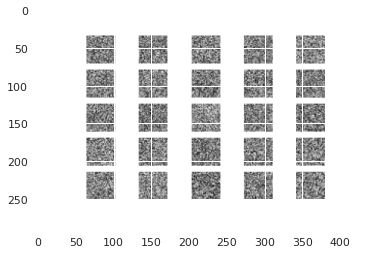

In [17]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

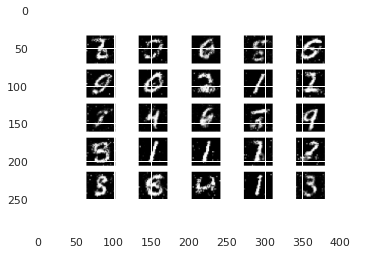

In [18]:
a = imread('gan_images/5000.png')
plt.imshow(a)

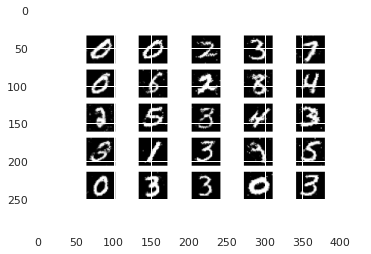

In [19]:
a = imread('gan_images/29800.png')
plt.imshow(a)

In [22]:
# Generating new image
sample_images(100000)

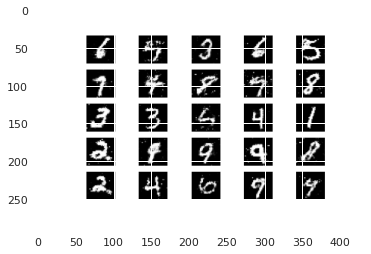

In [23]:
a = imread('gan_images/100000.png')
plt.imshow(a)